<a href="https://colab.research.google.com/github/srkhvx/Intelligent-Cyber-Security/blob/master/Copy_of_AI_Cybersecurity_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [10]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print(f"Epoch {epoch+1} Training loss: {running_loss/len(trainloader)}")

print('Finished Training')

Epoch 1 Training loss: 1.9573601539177663
Epoch 2 Training loss: 1.6909838111504265
Epoch 3 Training loss: 1.5930057514049207
Epoch 4 Training loss: 1.5388440405926131
Epoch 5 Training loss: 1.4985374907398468
Epoch 6 Training loss: 1.4644757065626666
Epoch 7 Training loss: 1.435165258777111
Epoch 8 Training loss: 1.407648916134749
Epoch 9 Training loss: 1.3842906300216684
Epoch 10 Training loss: 1.3630733200351295
Epoch 11 Training loss: 1.342881794933163
Epoch 12 Training loss: 1.3240593769361295
Epoch 13 Training loss: 1.3054424374152327
Epoch 14 Training loss: 1.2874416335464438
Epoch 15 Training loss: 1.2742062590616134
Epoch 16 Training loss: 1.2591825854747802
Epoch 17 Training loss: 1.2449063561913911
Epoch 18 Training loss: 1.2318388312064168
Epoch 19 Training loss: 1.218836308135401
Epoch 20 Training loss: 1.2075572369043783
Finished Training


In [12]:
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

Files already downloaded and verified


In [0]:
#models is trained. 
epsilons = [0, .05, .1, .15, .2, .25, .5]
pretrained_model = "/content/drive/My Drive/Colab Notebooks/CIFAR.pth"
use_cuda=True


In [0]:
PATH = "/content/drive/My Drive/Colab Notebooks/CIFAR.pth"
torch.save(net.state_dict(), PATH)

In [0]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    # Return the perturbed image
    return perturbed_image

In [0]:
def test(model, test_loader, epsilon):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
      
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 10):
                adv_ex = perturbed_data.squeeze().detach().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 10:
                adv_ex = perturbed_data.squeeze().detach().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    
    return final_acc, adv_examples

In [21]:
model_attack = Net()



# Load the pretrained model
model_attack.load_state_dict(torch.load(pretrained_model))
# alex_attack.load_state_dict(alex)

# Set the model in evaluation mode. In this case this is for the Dropout layers
model_attack.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [22]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model_attack, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)
    

Epsilon: 0	Test Accuracy = 2601 / 10000 = 0.2601
Epsilon: 0.05	Test Accuracy = 454 / 10000 = 0.0454
Epsilon: 0.1	Test Accuracy = 77 / 10000 = 0.0077
Epsilon: 0.15	Test Accuracy = 12 / 10000 = 0.0012
Epsilon: 0.2	Test Accuracy = 3 / 10000 = 0.0003
Epsilon: 0.25	Test Accuracy = 1 / 10000 = 0.0001
Epsilon: 0.5	Test Accuracy = 0 / 10000 = 0.0


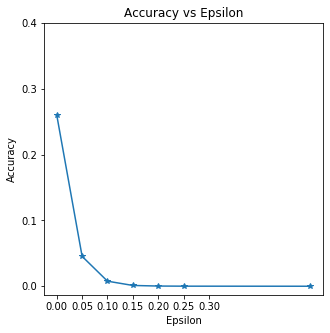

In [24]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 0.5, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [0]:
import numpy 
def convert_to_imshow_format(image):
  image = image / 2 + 0.5
  image = image.numpy()
  img = image.transpose(1,2,0)
  
  return img


In [27]:
len(examples[0])

10

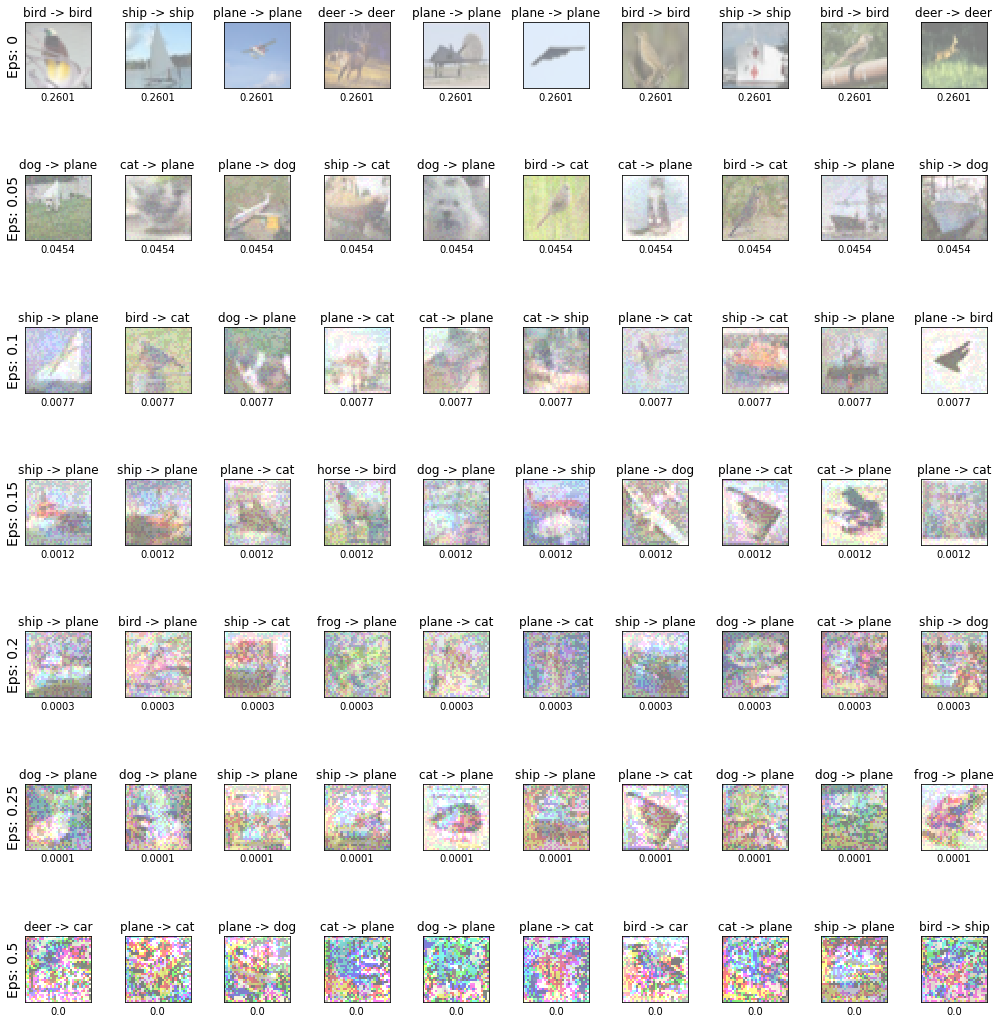

In [29]:

cnt = 0
plt.figure(figsize=(14,15))
li = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.xlabel(accuracies[i])
        plt.title("{} -> {}".format(li[int(orig)], li[int(adv)]))
        
        plt.imshow(convert_to_imshow_format(torch.tensor(ex)))
plt.tight_layout()
plt.show()